<a href="https://colab.research.google.com/github/jdcast/dl-final-project/blob/main/CPC_Image_Sequences_2D_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Script to train CPC network on images
 - network references: https://github.com/davidtellez/contrastive-predictive-coding/blob/master/train_model.py 
 - dataloader references: https://github.com/davidtellez/contrastive-predictive-coding/blob/master/data_utils.py and https://colab.research.google.com/drive/1FtT3_qF5jcqHDazesrxkdaOtd2mvimdl#scrollTo=_kN-xXH00mey

## Imports

In [1]:
import os
import pdb
import time
import random

%matplotlib inline
import torch as T
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import randrange
from random import choice
from random import uniform
from torchsummary import summary
from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from scipy.stats import entropy
import copy

from skimage import io

import itertools

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()

# Dataset 

## Mount Google Drive

In [2]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Directory

In [3]:
#address of data in google drive 
data_dir = "/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset"

## Display Sample of the Data

(538, 701, 3)


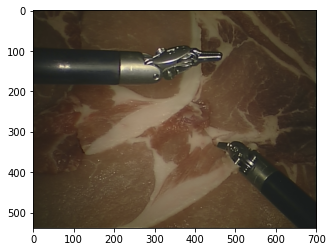

In [4]:
test_img_path = os.path.join(data_dir, "Video_01/images/000.png")
test_img = io.imread(test_img_path)
plt.imshow(test_img)
print(test_img.shape) #original img dimension

## Dataloader Architecture

In [8]:
FRAMES_PER_VIDEO = 300

class ImageDataset(Dataset):
    """
    Image Dataset
    """

    def __init__(self, data_dir, op, batch_size, terms, transform=False, predict_terms=1):
      """
      Args:
          input_dir: input data path to images and masks
          op: 'train' or 'test'
          batch_size: number of sequences per batch
          terms: number of past images in sequences (i.e. the terms in the sequence we train on)
          transform: boolean, whether to apply transformations
          predict_terms: number of future images in sequences to predict the embeddings of (i.e. the predictions by the RNN model)
      """
      assert terms > 0, 'number of past terms in sequence must be greater than 0'
      assert predict_terms > 0, 'number of future terms in sequence to predict must be greater than 0'
      assert batch_size > 0, 'batch size must be greater than 0'
      # assert frame > 1, 'number of frames should be an integer greater than 1'

      # because we are not linearly iterating through the images, we do not know a priori how many batches there are per epoch
      # so we must calculate the number of batches by considering the number of samples (i.e. image sequences) that we'd like to draw per epoch
      try:
        if op == 'train':
            self.len = FRAMES_PER_VIDEO * 14 // (terms + predict_terms) # total 14 videos each with 300 pictures
        elif op == 'test':
            self.len = FRAMES_PER_VIDEO * 6 // (terms + predict_terms) # videos in other's folder total video(15-20)
        self.n_batches = self.len // batch_size
      except ValueError:
        print ('op should be train or test.')

      # self.frame = frame
      self.op = op # specify train or test 
      self.data_dir = data_dir
      self.transform = transform
      self.mask_num = 2 # Only 2 output class labels.

      self.batch_size = batch_size
      self.terms = terms
      self.predict_terms = predict_terms
    
    def __len__(self):
        """
          for training: using videos from 01-14 each with 300 pics (14 * 300 img in total)
          for testing: using videos from 15-20 each with 300 pics (6 * 300 img in total)
        """
        return self.len

    
    def __getitem__(self, idx):
        """
          returning corresponding img and mask from dataset folder 
        """
        # randomly choose a video to extract sequences from
        if self.op == 'train':
            video_id = (idx * (self.terms + self.predict_terms)) // 300 + 1 #returning the number part of video's name str (i.e. "Video_01"'s '01')
            video_name = str(video_id).zfill(2) #returning the number part of video's name str (i.e. "Video_01"'s '01')
            img_dir = os.path.join(self.data_dir, "Video_" + video_name, "images/")
            mask_dir = os.path.join(self.data_dir, "Video_" + video_name, "ground_truth/")
        else:
            video_id = (idx * (self.terms + self.predict_terms)) // 300 + 15
            video_name = str(video_id).zfill(2)
            img_dir = os.path.join(self.data_dir, "others/Video_" + video_name, "images/")
            mask_dir = os.path.join(self.data_dir, "others/Video_" + video_name, "ground_truth/")

        # determine if sample will be positive or negative 
        is_positive = random.uniform(0, 1) < 0.2

        # choose random starting index for sequence from video
        # we have to be careful so as to make sure our required sequence length can be extracted i.e. if the sequence is chosen too close to the end of the video
        if is_positive: # must fit the previous and future terms
          sentence_label = 1
          start_idx = randrange(FRAMES_PER_VIDEO - (self.terms + self.predict_terms)) + 1 # plus 1 since randrange doesn't include end in range (images are 0 indexed)
          frames = [start_idx + i for i in range(self.terms + self.predict_terms)]
        else: # only worry about previous terms since future terms don't have to be in sequence with previous terms
          sentence_label = 0
          start_idx = randrange(FRAMES_PER_VIDEO - self.terms) + 1
          frames = [start_idx + i for i in range(self.terms)]

          # add on random frames for the predict terms
          for j in range(self.predict_terms):
            
            # don't choose one of the currently chosen frames
            term = choice([i for i in range(300) if i not in frames])
            frames.append(term)

        ## modify the frames as desired
        # one-off issue with torch.cat needing nonempty tensor at start of for loop so we place the first iteration outside the loop
        img_name = img_dir + str(frames[0]).zfill(3) + ".png"
        print(img_name)
        mask_name = mask_dir + str(frames[0]).zfill(3) + '.png'
        
        img = Image.open(img_name)
        mask = Image.open(mask_name)

        # Apply data augmentations, if any.
        if self.transform:
            img, mask = self.augment(img, mask)
        
        mask = np.array(mask)
        
        h, w, c  = mask.shape
        mask_value = {0:0, 1:255}
        
        # Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            new_mask[:, :, idx] = mask[:, :, 0] == mask_value[idx]

        # Transform to tensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(new_mask)

        img = torch.unsqueeze(img, 1)
        mask = torch.unsqueeze(mask, 1)  

        for i, frame in enumerate(frames):
            if i > 0:
              img_name = img_dir + str(frame).zfill(3) + ".png"
              mask_name = mask_dir + str(frame).zfill(3) + ".png"
              print(img_name)
              
              img_next = Image.open(img_name)
              mask_next = Image.open(mask_name)

              # Apply data augmentations, if any.
              if self.transform:
                  img_next, mask_next = self.augment(img_next, mask_next)
              
              mask_next = np.array(mask_next)
              
              # Convert grey-scale label to one-hot encoding
              new_mask = np.zeros((h, w, self.mask_num))
              for idx in range(self.mask_num):
                  new_mask[:, :, idx] = mask_next[:, :, 0] == mask_value[idx]

              # Transform to tensor
              img_next = TF.to_tensor(img_next)
              mask_next = TF.to_tensor(new_mask)
              
              img_next = torch.unsqueeze(img_next, 1)
              mask_next = torch.unsqueeze(mask_next, 1)
              
              img = torch.cat((img,img_next),dim=1)
              mask = torch.cat((mask,mask_next),dim=1)

        return img, mask, sentence_label, T.tensor(frames)

    def augment(self, img, mask):

        
        if np.random.random() > 0.5:

            # Random horizontal flipping
            if np.random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)

            # Random vertical flipping
            if np.random.random() > 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)

            # # Random brightness change
            # if np.random.random() > 0.67:
            #     img = TF.adjust_brightness(img, np.random.rand() + 0.5)

            # # Random gaussian blur
            # if np.random.random() > 0.8:
            #     img = TF.gaussian_blur(img, [5, 5])
        
        return img, mask

## Test Dataloaders

/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_10/images/114.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_10/images/115.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_10/images/116.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_10/images/117.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_10/images/073.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_10/images/020.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_02/images/281.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset/Video_02/images/282.png
/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic

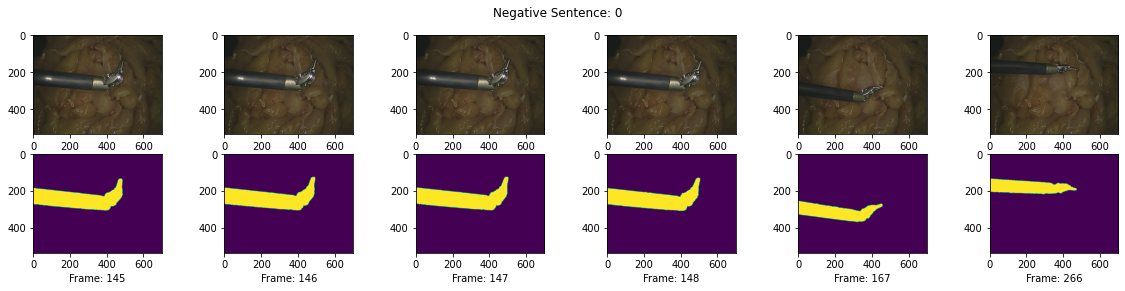

torch.Size([4, 3, 6, 538, 701]) torch.Size([4, 2, 6, 538, 701]) torch.Size([4]) torch.Size([4, 6])


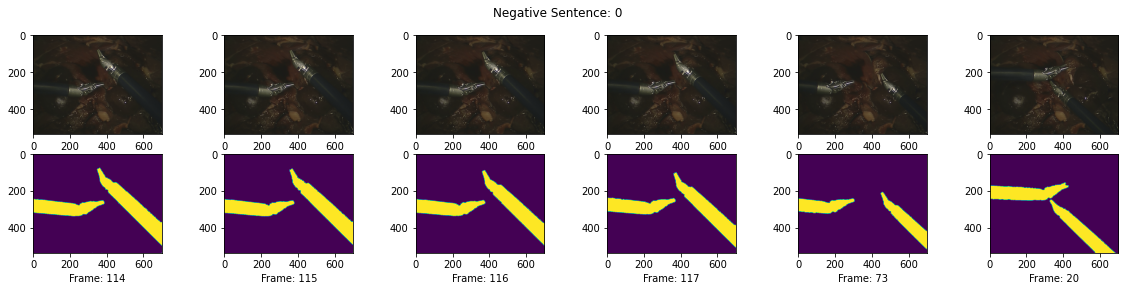

In [9]:
batch_size = 4
terms = 4
predict_terms = 2

train_dataset = ImageDataset(data_dir, op='train', batch_size=4, terms=terms, transform=False, predict_terms=predict_terms)
test_dataset = ImageDataset(data_dir, op='test', batch_size=4, terms=terms, transform=False, predict_terms=predict_terms)

train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_imgs, train_masks, train_sentence_labels, train_frame_numbers = next(iter(train_dataloader))
test_imgs, test_masks, test_sentence_labels, test_frame_numbers = next(iter(test_dataloader))

# show first sentence from a batch from test dataloader
print(test_imgs.shape, test_masks.shape, test_sentence_labels.shape, test_frame_numbers.shape)
fig = plt.figure(figsize=(20, 4))
columns = terms + predict_terms
rows = 2

for i in range(rows):
  for j in range(columns):
    if i == 0:
      image = torch.permute(test_imgs[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)
    else:
      image = torch.argmax(test_masks[0], dim=0)[j].cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)
    plt.xlabel("Frame: {}".format(test_frame_numbers[0, j].cpu().numpy()))
 
fig.suptitle("Positive Sentence: 1" if test_sentence_labels[0].cpu().data == 1 else "Negative Sentence: 0")
plt.show()

# show first sentence from a batch from test dataloader
print (train_imgs.shape, train_masks.shape, train_sentence_labels.shape, train_frame_numbers.shape)
fig = plt.figure(figsize=(20, 4))
columns = terms + predict_terms
rows = 2

for i in range(rows):
  for j in range(columns):
    if i == 0:
      image = torch.permute(train_imgs[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)
    else:
      image = torch.argmax(train_masks[0], dim=0)[j].cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)
    plt.xlabel("Frame: {}".format(train_frame_numbers[0, j].cpu().numpy()))

fig.suptitle("Positive Sentence: 1" if train_sentence_labels[0].cpu().data == 1 else "Negative Sentence: 0")
plt.show()

# Models

## Hyperparameters

In [ ]:
# latent space dimensionality (e.g. dimensionality of output space of encoder)
code_size = 128

# number of features in hidden state of RNN
hidden_size = 256

# number of future frames to predict
predict_terms = 4

## Network Encoder

In [ ]:
# Encoder
# Uses linear layers for fully connected layers (i.e. not fully convolutional)

class network_encoder(nn.Module):
    # initializers
    def __init__(self, input_channel, code_size):
        super(network_encoder, self).__init__()

        # convolution layers
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=64, kernel_size=3, stride=2)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
        self.bnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
        self.bnorm4 = nn.BatchNorm2d(64)
        
        # # fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=86016, out_features=256)
        self.bnorm5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features=256, out_features=code_size)
 
        # activations
        self.leakyRelu = nn.LeakyReLU()

    # weight_init
    # def weight_init(self, mean, std):
    def weight_init(self):
        for m in self._modules:
            # normal_init(self._modules[m], mean, std)
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                if m.bias is not None:
                    m.bias.data.zero_()
                torch.nn.init.kaiming_uniform_(m.weight.data)

    # forward method
    def forward(self, input):
      out = self.conv1(input) 
      out = self.bnorm1(out)
      out = self.leakyRelu(out)
      out = self.conv2(out) 
      out = self.bnorm2(out)
      out = self.leakyRelu(out)
      out = self.conv3(out) 
      out = self.bnorm3(out)
      out = self.leakyRelu(out) 
      out = self.conv4(out) 
      out = self.bnorm4(out)
      out = self.leakyRelu(out) 
      out = self.flatten(out)
      out = self.fc1(out)
      out = self.bnorm5(out)
      out = self.leakyRelu(out)
      out = self.fc2(out)

      return out

## Print Encoder Architecture

In [ ]:
encoder_model = network_encoder(input_channel=3,code_size=10)
summary(encoder_model, (3, 538, 701))

## Network Autoregressive
 - RNN
  - uses GRU

In [ ]:
class network_autoregressive(nn.Module):
    # initializers
    def __init__(self, input_size, hidden_size=256):
      '''
      hidden_size: is a hyperparameter and should likely be a power of 2
      '''
      super(network_autoregressive, self).__init__()

      # GRU
      self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1)

    # forward method
    def forward(self, input):
      # we don't provide a hidden state, by default it's all zeros
      out, h = self.gru(input)

      return out, h

~## Print RNN Architecture~ not clear how to use summary() with GRU

In [ ]:
# rnn_model = network_autoregressive(code_size=10, hidden_size=256)
# summary(rnn_model, (1, 10))

In [ ]:
# simple GRU test to look at output

rnn = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)
print(output.shape)

## Lambda Layer 
 - analogous to keras.layers.Lambda 
- https://discuss.pytorch.org/t/how-to-implement-keras-layers-core-lambda-in-pytorch/5903

In [ ]:
class Lambda(nn.Module):
    def __init__(self, lambd):
        super(Lambda, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

## Network Prediction  
- Define mapping between context (produced by RNN) and multiple, future embedding predictions

In [ ]:
class network_prediction(nn.Module):

    ''' Define the context mapping to embedding vectors of future frames '''
    def __init__(self, hidden_size, code_size, terms, predict_terms):
      super(network_prediction, self).__init__()

      # linear layer for each output
      self.linears = nn.ModuleList()
      for i in range(predict_terms):
        # original code used a "linear" activation so we omit an activation on the layer
        self.linears.append(nn.Linear(in_features=terms*hidden_size, out_features=code_size))

    def forward(self, context):
      # squash all but batch dimension so will work with linear layers
      context = context.contiguous().view(context.size(0), -1)

      # return a tensor so downstream CPCLayer's dot product works
      outputs = self.linears[0](context)
      outputs = T.unsqueeze(outputs, 1) # we will stack along the temporal dimension

      for i, l in enumerate(self.linears):
        if i > 0:
          next_output = T.unsqueeze(l(context), 1)
          outputs = T.cat((outputs, next_output), dim=1)

      return outputs

## TimeDistributed Layer to mimic Kera's TimeDistributed layer: 
- https://stackoverflow.com/questions/62912239/tensorflows-timedistributed-equivalent-in-pytorch

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(2), x.size(3), x.size(4))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

## CPCLayer
 - Computes dot product between true and predicted embedding vectors

In [ ]:
class CPCLayer(nn.Module):
  def __init__(self, **kwargs):
    super(CPCLayer, self).__init__(**kwargs)

  def forward(self, y_preds, y_encoded):
    ''' 
    y_preds: predictions of frames corresponding to predict_terms
    y_encoded: encoded gt frames corresponding to predict_terms
    '''
    dot_product = T.mean(y_encoded*y_preds, axis=-1)
    dot_product = T.mean(dot_product, axis=-1) # average along the temporal dimension

    # convert to probabilities
    dot_product_probs = T.sigmoid(dot_product) 

    return dot_product_probs
  

## Network CPC
TODO

In [ ]:
class network_cpc(nn.Module):
  ''' 
  Define the CPC network combining encoder and autoregressive model 
  
  predict_terms: number of future images in sequences to predict the embeddings of (i.e. the predictions by the RNN model)
  code_size: latent space dimensionality (e.g. dimensionality of output space of encoder)
  '''

  def __init__(self, terms, predict_terms, code_size, hidden_size):
    super(network_cpc, self).__init__()
    
    self.encoder_model = network_encoder(input_channel=3, code_size=code_size)
    self.timeDistributed_encoder = TimeDistributed(self.encoder_model, batch_first=True)
    self.network_autoregressive = network_autoregressive(input_size=code_size, hidden_size=hidden_size)
    self.network_prediction = network_prediction(hidden_size=hidden_size, code_size=code_size, terms=terms, predict_terms=predict_terms)
    self.cpcLayer = CPCLayer()

  def forward(self, x, y):
    x_encoded = self.timeDistributed_encoder(x)
    context, hidden_state = self.network_autoregressive(x_encoded)
    y_preds = self.network_prediction(context)
    y_encoded = self.timeDistributed_encoder(y)
    dot_product_probs = self.cpcLayer(y_preds, y_encoded)

    return dot_product_probs

# Train

## Evaluation

In [ ]:
def eval(terms, verbose = 1, loader=None, ltype="", model=None, loss_metric=None):
    correct = 0
    num_batches = 0
    loss_sum = 0
    num_samples = 0
    for i, (images, masks, sentence_labels, frame_numbers) in enumerate(loader):
        print("Eval -> {} Batch: {}".format(ltype, i))

        sentence_labels = sentence_labels.float()

        # permute the time and channel dimensions for easier handling during model inference
        # dataloader returns batches in shape: [batch_size, channels, time, height, width] but we would like [batch_size, time, channels, height, width]
        images = torch.permute(images, (0, 2, 1, 3, 4))

        # split the images into the their respective terms and predict_terms groupings
        images_terms = images[:, :terms, :, :, :] # terms
        images_predict_terms = images[:, terms:, :, :, :] # predict_terms

        if gpu_boole:
          images_terms = images_terms.cuda()
          images_predict_terms = images_predict_terms.cuda()
          sentence_labels = sentence_labels.cuda()
        
        sentence_preds = model(images_terms, images_predict_terms)

        # threshold predictions to binary values
        sentence_preds_thresh = (sentence_preds > 0.5).float()

        num_samples += sentence_labels.size(0)
        num_batches += 1
        correct += (sentence_preds_thresh.float() == sentence_labels.float()).sum()
        loss = loss_metric(sentence_preds, sentence_labels)
        loss_sum += loss.detach()
        
    if verbose:
        print("{} accuracy: {}".format(ltype, (100.0 * correct / num_samples)))
        print("{} loss: {}".format(ltype, (loss_sum.cpu().data.numpy().item() / num_batches)))

    return 100.0 * correct / num_samples, loss_sum.cpu().data.numpy().item() / num_batches

## Train Harness

In [ ]:
def train(epochs, batch_size, output_dir, code_size, image_size, lr=1e-4, terms=4, predict_terms=4, hidden_size=256, verbose=1):
  '''
  epochs: number of epochs to train 
  batch_size: batch size to use
  output_dir: directory to hold saved models and checkpoints
  code_size: length of embedding vector (i.e. output space of encoder)
  image_size: (h,w) of images
  lr: learning rate
  terms: number of terms for autoregressive model to ingest
  predict_terms: number of terms for autoregressive model to predict embedding vectors for
  hidden_size: length of hidden vector of autoregressive model
  verbose: 0 or 1, 0 = quiet, 1 = print
  '''
  # Data
  train_dataset = ImageDataset(data_dir, op='train', batch_size=batch_size, terms=terms, transform=False, predict_terms=predict_terms)
  test_dataset = ImageDataset(data_dir, op='test', batch_size=batch_size, terms=terms, transform=False, predict_terms=predict_terms)

  print("Number of batches in train dataset: {}".format(len(train_dataset) // batch_size))
  print("Number of batches in test dataset: {}".format(len(test_dataset) // batch_size))

  train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  # Model
  model = network_cpc(terms=terms, predict_terms=predict_terms, code_size=code_size, hidden_size=hidden_size)
  summary(model, [(terms, 3, image_size[0], image_size[1]), (predict_terms, 3, image_size[0], image_size[1])]) # model summary needs both inputs specified
  model_time_tag = time.time()

  # Optimizer, Learning Rate Scheduler, Loss
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=1/3, patience=2, min_lr=1e-4)
  lr_metric = 0 # used for learning rate policy "plateau"
  loss_metric = nn.BCELoss()

  test_loss_epoch_store = []
  train_loss_epoch_store = []
  test_acc_epoch_store = []
  train_acc_epoch_store = []

  print("Starting Training")
  #training loop:
  for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (train_imgs, train_masks, train_sentence_labels, train_frame_numbers) in enumerate(train_dataloader):
      print("Train -> Batch: {}".format(i))
      print(train_imgs.shape)
      print(train_sentence_labels.shape)
      print(train_frame_numbers)

      train_sentence_labels = train_sentence_labels.float()

      # permute the time and channel dimensions for easier handling during model inference
      # dataloader returns batches in shape: [batch_size, channels, time, height, width] but we would like [batch_size, time, channels, height, width]
      train_imgs = torch.permute(train_imgs, (0, 2, 1, 3, 4))

      # split the images into the their respective terms and predict_terms groupings
      train_imgs_terms = train_imgs[:, :terms, :, :, :] # terms
      train_imgs_predict_terms = train_imgs[:, terms:, :, :, :] # predict_terms

      if gpu_boole:
        train_imgs_terms = train_imgs_terms.cuda()
        train_imgs_predict_terms = train_imgs_predict_terms.cuda()
        train_sentence_labels = train_sentence_labels.cuda()

      #loss calculation and gradient update:
      if i > 0 or epoch > 0:
        optimizer.zero_grad()
      sentence_preds = model.forward(train_imgs_terms, train_imgs_predict_terms)
      loss = loss_metric(sentence_preds, train_sentence_labels)
      loss.backward()
                    
      ##performing parameter update:
      optimizer.step()

    ##performing lr update
    scheduler.step(lr_metric)

    if epoch % 1 == 0:
      print("Epoch",epoch+1,':')
      print("LR: {}".format(optimizer.param_groups[0]['lr'])) # ReduceLROnPlateau doesn't have get_last_lr() attribute: https://discuss.pytorch.org/t/shouldnt-reducelronplateau-super-optimizer-in-its-init/89390
    
    # validation
    model.eval()
    with torch.no_grad():
      train_perc, train_loss = eval(terms=terms, verbose=verbose, loader=train_dataloader, ltype="Train", model=model, loss_metric=loss_metric)
      test_perc, test_loss = eval(terms=terms, verbose=verbose, loader=test_dataloader, ltype="Test", model=model, loss_metric=loss_metric)
    model.train()

    test_loss_epoch_store.append(test_loss)
    train_loss_epoch_store.append(train_loss)
    test_acc_epoch_store.append(test_perc.cpu().data.numpy().item())
    train_acc_epoch_store.append(train_perc.cpu().data.numpy().item())

    # save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_metric,
        }, os.path.join(output_dir, 'cpc_images_network_{}_epoch_{}_ckpt.pth'.format("{}".format(model_time_tag).replace('.', '_'), epoch)))

    time2 = time.time() #timekeeping
    if epoch % 1 == 0:
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
      print()

  ## Plotting epoch-wise train loss curve:
  plt.plot(train_loss_epoch_store, '-o', label = 'train_loss', color = 'blue')
  plt.plot(test_loss_epoch_store, '-*', label = 'test_loss', color = 'red')
  plt.xlabel('Epoch Number')
  plt.title('Train and Test Loss At Last Epoch')
  plt.legend()
  plt.show()

  ## Plotting epoch-wise test accuracy curve:
  plt.plot(train_acc_epoch_store, '-o', label = 'train_acc', color = 'blue')
  plt.plot(test_acc_epoch_store, '-*', label = 'test_acc', color = 'red')
  plt.xlabel('Epoch Number')
  plt.title('Train and Test Accuracy At Last Epoch')
  plt.legend()
  plt.show()

  ## save entire model, doesn't seem possible to save just the encoder: https://discuss.pytorch.org/t/save-part-of-the-model/28519
  torch.save(model.state_dict(), os.path.join(output_dir, 'cpc_images_network_{}.pth'.format("{}".format(model_time_tag).replace('.', '_'))))

  # save just encoder
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.encoder_model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss_metric,
      }, os.path.join(output_dir, 'cpc_images_encoder_{}.pth'.format("{}".format(model_time_tag).replace('.', '_'))))

  return train_loss_epoch_store, test_acc_epoch_store, train_acc_epoch_store, model

## Start Training

In [ ]:
train_loss_epoch_store, test_acc_epoch_store, train_acc_epoch_store, model = train(epochs=10, 
                                                                                   batch_size=5, 
                                                                                   output_dir='/content/drive/MyDrive/JHU/Courses/Deep Learning/final_project/temp', 
                                                                                   code_size=10, 
                                                                                   lr=1e-4, 
                                                                                   terms=4, 
                                                                                   predict_terms=2, 
                                                                                   hidden_size=256,
                                                                                   image_size=(538, 701), 
                                                                                   verbose=1)